## K-MEANS MODEL

In [6]:
# Import the libaray
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report



In [25]:
# Importing the dataset
fifa = pd.read_csv("kl.csv", encoding='ISO-8859-1')
fifa.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31.0,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94.0,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,226.5M
1,1,20801,Cristiano Ronaldo,33.0,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94.0,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,127.1M
2,2,190871,Neymar Jr,26.0,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92.0,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,228.1M
3,3,193080,De Gea,27.0,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91.0,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,138.6M
4,4,192985,K. De Bruyne,27.0,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91.0,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,196.4M


# Exploaratory Data Aanalysis

In [26]:
fifa.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingT

In [27]:
fifa['Position'].unique()

array(['RF', 'ST', 'LW', 'GK', 'RCM', 'LF', 'RS', 'RCB', 'LCM', 'CB',
       'LDM', 'CAM', 'CDM', 'LS', 'LCB', 'RM', 'LAM', 'LM', 'LB', 'RDM',
       'RW', 'CM', 'RB', 'RAM', 'CF', 'RWB', 'LWB', nan], dtype=object)

## Data Cleaning

In [28]:
fifa.isnull().sum().sort_values(ascending=False).head(15)

Loaned From    16943
LWB             2085
LCM             2085
RS              2085
LW              2085
LF              2085
CF              2085
RF              2085
RW              2085
LAM             2085
CAM             2085
RAM             2085
LM              2085
CM              2085
LS              2085
dtype: int64

In [29]:
# Standardize column names (lowercase + underscores)
cols_to_drop = ['Unnamed: 0', 'Photo', 'Flag', 'Club Logo']
fifa_cleaned = fifa.drop(columns=cols_to_drop, errors='ignore')
fifa_cleaned.columns = (
    fifa_cleaned.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
)

In [30]:
# Convert currency strings ('€110.5M', '€200K', etc.) to numeric values
def convert_currency(value):
    """Convert FIFA currency values (e.g. €110.5M, €200K) to float in Euros."""
    if isinstance(value, str):
        value = value.replace('€', '').replace('K', 'e3').replace('M', 'e6')
        try:
            return float(eval(value))
        except:
            return None
    return value

for col in ['Value', 'Wage', 'Release Clause']:
    if col in fifa_cleaned.columns:
        fifa_cleaned[col] = fifa_cleaned[col].apply(convert_currency)
        fifa_cleaned[col].fillna(fifa_cleaned[col].median(), inplace=True)


In [31]:
# Remove duplicates
fifa_cleaned.drop_duplicates(inplace=True)


In [32]:
# Fill missing categorical data with "Unknown"
categorical_cols = fifa_cleaned.select_dtypes(include='object').columns
fifa_cleaned[categorical_cols] = fifa_cleaned[categorical_cols].fillna('Unknown')


In [33]:
# Fill missing numeric data with median values
numeric_cols = fifa_cleaned.select_dtypes(include=['int64', 'float64']).columns
fifa_cleaned[numeric_cols] = fifa_cleaned[numeric_cols].fillna(fifa_cleaned[numeric_cols].median())


In [34]:
#Removing columns that are redunant
fifa_cleaned = fifa.drop(columns=[
    'ID', 'Photo', 'Flag', 'Club Logo', 'Real Face', 'Body Type',
    'Joined', 'Loaned From', 'Contract Valid Until', 'Jersey Number',
    'Release Clause'
], errors='ignore')

print("Shape after dropping irrelevant columns:", fifa_cleaned.shape)


Shape after dropping irrelevant columns: (18207, 78)


Filing the missing numeric and catergorical values

In [35]:
# Filling missing numeric values with the column mean
numeric_cols = fifa_cleaned.select_dtypes(include='number').columns
fifa_cleaned[numeric_cols] = fifa_cleaned[numeric_cols].fillna(fifa_cleaned[numeric_cols].mean())

# Filling missing categorical values with the most common entry
categorical_cols = fifa_cleaned.select_dtypes(include='object').columns
fifa_cleaned[categorical_cols] = fifa_cleaned[categorical_cols].fillna(fifa_cleaned[categorical_cols].mode().iloc[0])


Specific Cleaning for the Model

In [36]:
#Simplifying the positions into labels for the model

if 'Simplified_Role' not in fifa_cleaned.columns:
    def simplify_role(pos):
        if pos in ['ST', 'CF', 'LW', 'RW', 'LF', 'RF']:
            return 'Attacker'
        elif pos in ['CM', 'CAM', 'CDM', 'RM', 'LM']:
            return 'Midfielder'
        elif pos in ['CB', 'LB', 'RB', 'LWB', 'RWB']:
            return 'Defender'
        else:
            return 'Other'
    fifa_cleaned['Simplified_Role'] = fifa_cleaned['Position'].apply(simplify_role)


# Feature Engineering for the K-Means Model

In [37]:
# Selecting the required Features
selected_features = [
    'Finishing', 'ShotPower', 'Acceleration', 'Dribbling',  # Attack
    'Interceptions', 'StandingTackle', 'Strength', 'Aggression',  # Defense
    'ShortPassing', 'Vision', 'BallControl', 'Reactions'  # Midfield
]

# Drop rows with missing values in selected columns
fifa_selected = fifa_cleaned[selected_features + ['Simplified_Role']].dropna()
fifa_selected.head()

,Finishing,ShotPower,Acceleration,Dribbling,Interceptions,StandingTackle,Strength,Aggression,ShortPassing,Vision,BallControl,Reactions,Simplified_Role
0,95.0,85.0,91.0,97.0,22.0,28.0,59.0,48.0,90.0,94.0,96.0,95.0,Attacker
1,94.0,95.0,89.0,88.0,29.0,31.0,79.0,63.0,81.0,82.0,94.0,96.0,Attacker
2,87.0,80.0,94.0,96.0,36.0,24.0,49.0,56.0,84.0,87.0,95.0,94.0,Attacker
3,13.0,31.0,57.0,18.0,30.0,21.0,64.0,38.0,50.0,68.0,42.0,90.0,Other
4,82.0,91.0,78.0,86.0,61.0,58.0,75.0,76.0,92.0,94.0,91.0,91.0,Other


# Feature Scaling

In [42]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(fifa_selected[selected_features])


In [50]:
#Applying K-means Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
fifa_selected['Predicted_Role'] = kmeans.fit_predict(X_scaled)


NameError: name 'fifa_selected' is not defined

# Visualizing the Clusters of the k-Means

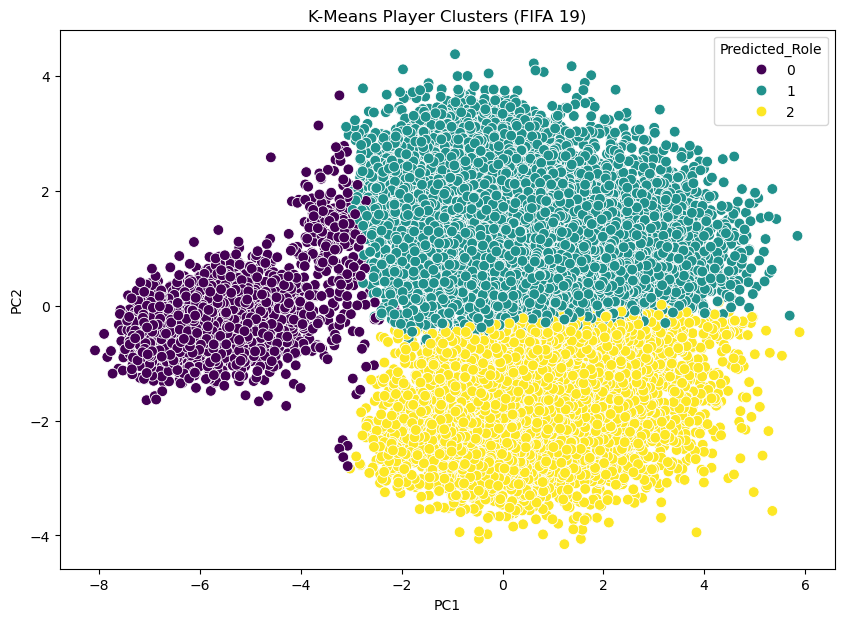

In [44]:
# Visualalizing the clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
fifa_selected['PC1'] = X_pca[:, 0]
fifa_selected['PC2'] = X_pca[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=fifa_selected,
    x='PC1', y='PC2',
    hue='Predicted_Role',
    palette='viridis',
    s=60
)
plt.title('K-Means Player Clusters (FIFA 19)')
plt.show()


# Evaluating the Model

In [45]:
# Compare the majority label in each cluster
mapping = {}
for cluster in range(3):
    mode_label = fifa_selected[fifa_selected['Predicted_Role'] == cluster]['Simplified_Role'].mode()[0]
    mapping[cluster] = mode_label

# Map clusters to actual roles
fifa_selected['Predicted_Role_Mapped'] = fifa_selected['Predicted_Role'].map(mapping)


In [46]:
#calculateing how close the predicted clusters are to the true roles.
silhouette = silhouette_score(X_scaled, kmeans.labels_)
f1 = f1_score(fifa_selected['Simplified_Role'], fifa_selected['Predicted_Role_Mapped'], average='weighted')
acc = accuracy_score(fifa_selected['Simplified_Role'], fifa_selected['Predicted_Role_Mapped'])

print(f"Silhouette Score: {silhouette:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Accuracy: {acc:.3f}")


Silhouette Score: 0.277
F1 Score: 0.469
Accuracy: 0.523


# Confusion Matrix 



🧩 Confusion Matrix:
[[   0  149 2907   12]
 [   0 4283   80  193]
 [   0 2323 3196    0]
 [   0 2337  683 2044]]

Detailed Report:
              precision    recall  f1-score   support

    Attacker       0.00      0.00      0.00      3068
    Defender       0.47      0.94      0.63      4556
  Midfielder       0.47      0.58      0.52      5519
       Other       0.91      0.40      0.56      5064

    accuracy                           0.52     18207
   macro avg       0.46      0.48      0.43     18207
weighted avg       0.51      0.52      0.47     18207



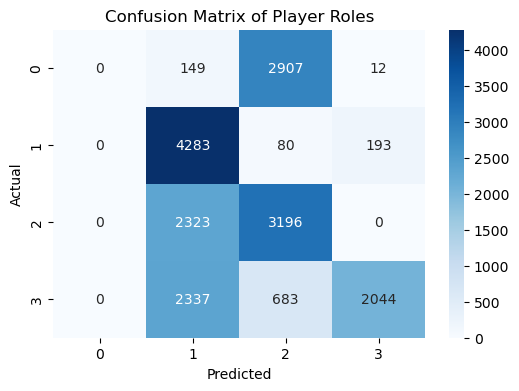

              precision    recall  f1-score   support

    Attacker       0.00      0.00      0.00      3068
    Defender       0.47      0.94      0.63      4556
  Midfielder       0.47      0.58      0.52      5519
       Other       0.91      0.40      0.56      5064

    accuracy                           0.52     18207
   macro avg       0.46      0.48      0.43     18207
weighted avg       0.51      0.52      0.47     18207



In [47]:

if {'Simplified_Role', 'Predicted_Role_Mapped'}.issubset(fifa_selected.columns):
    cm = confusion_matrix(fifa_selected['Simplified_Role'], fifa_selected['Predicted_Role_Mapped'])
    print("\n🧩 Confusion Matrix:")
    print(cm)

    print("\nDetailed Report:")
    print(classification_report(
        fifa_selected['Simplified_Role'],
        fifa_selected['Predicted_Role_Mapped'],
        zero_division=0
    ))

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix of Player Roles')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
else:
    print("Confusion matrix not displayed — required columns missing or empty.")


print(classification_report(
    fifa_selected['Simplified_Role'],
    fifa_selected['Predicted_Role_Mapped'],
    zero_division=0
))



# k-Value

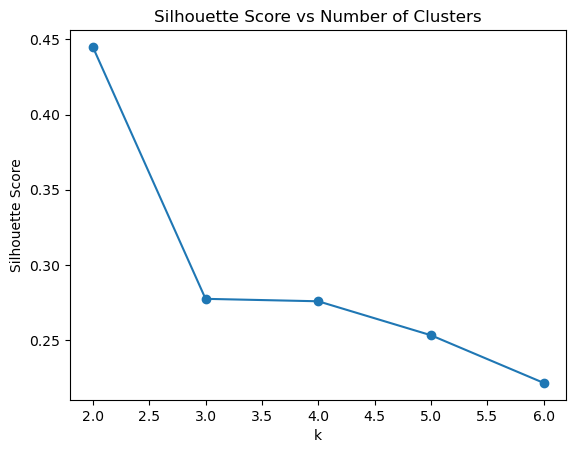

In [48]:
#Finding the best k-value
scores = []
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    scores.append(silhouette_score(X_scaled, kmeans.labels_))

plt.plot(range(2,7), scores, marker='o')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.show()


## Visualizations and Statistics

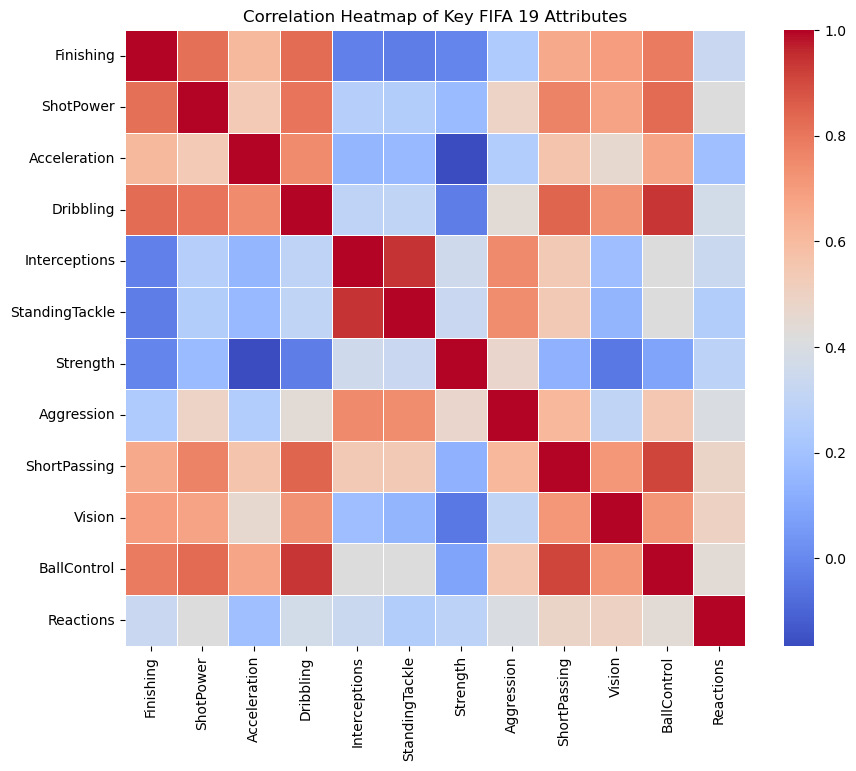

In [49]:
plt.figure(figsize=(10,8))
sns.heatmap(
    fifa_selected[selected_features].corr(),
    cmap='coolwarm',
    annot=False,
    linewidths=0.5
)
plt.title('Correlation Heatmap of Key FIFA 19 Attributes')
plt.show()


In [46]:
# First, check what's in these columns
features = ['Overall', 'Potential', 'Value', 'Wage']

print("Data types and sample values:")
for feature in features:
    if feature in fifa.columns:
        print(f"\n{feature}:")
        print(f"  Data type: {fifa[feature].dtype}")
        print(f"  Sample values: {fifa[feature].head(3).tolist()}")
    else:
        print(f"\n{feature}: Column not found!")

# Then clean and plot based on what you find

Data types and sample values:

Overall:
  Data type: float64
  Sample values: [94.0, 94.0, 92.0]

Potential:
  Data type: int64
  Sample values: [94, 94, 93]

Value:
  Data type: object
  Sample values: ['\x80110.5M', '\x8077M', '\x80118.5M']

Wage:
  Data type: object
  Sample values: ['\x80565K', '\x80405K', '\x80290K']


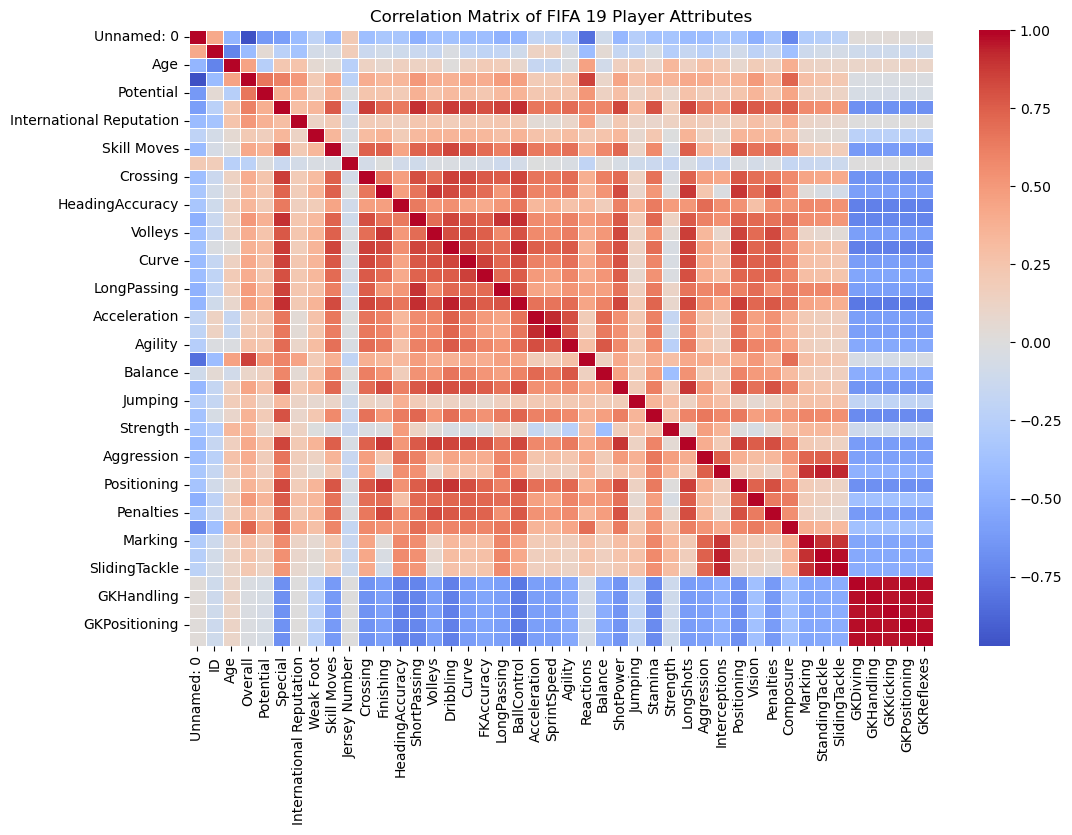

In [ ]:
numeric_features = fifa.select_dtypes(include=['int64', 'float64'])
corr_matrix = numeric_features.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix of FIFA 19 Player Attributes')
plt.show()


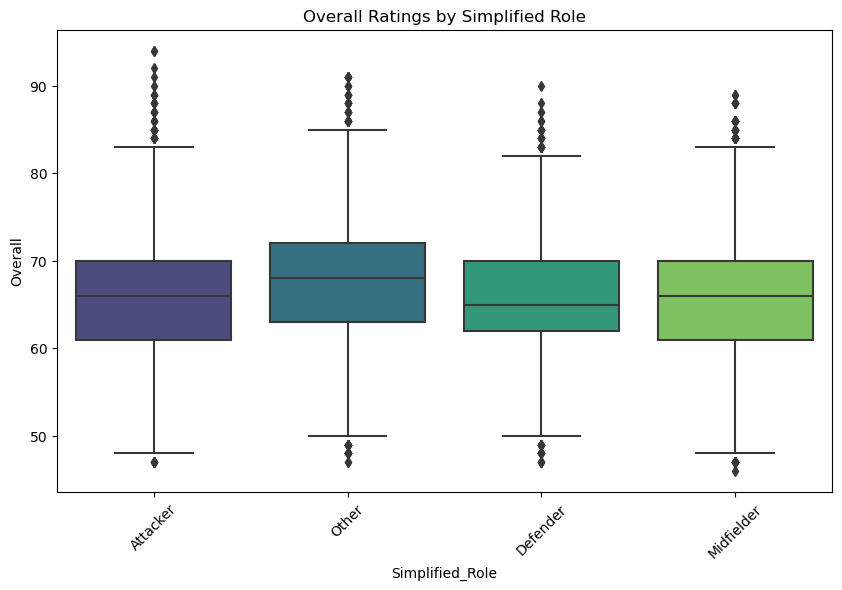

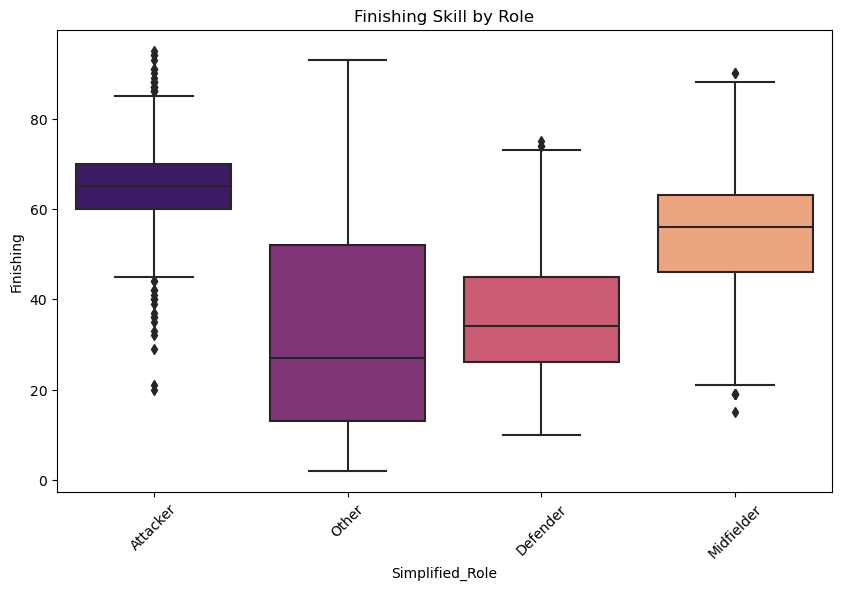

In [ ]:
key_attributes = ['Finishing', 'ShortPassing', 'Dribbling', 'Defending', 'Physical']

plt.figure(figsize=(10,6))
sns.boxplot(data=fifa_cleaned, x='Simplified_Role', y='Overall', palette='viridis')
plt.title('Overall Ratings by Simplified Role')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(data=fifa_cleaned, x='Simplified_Role', y='Finishing', palette='magma')
plt.title('Finishing Skill by Role')
plt.xticks(rotation=45)
plt.show()

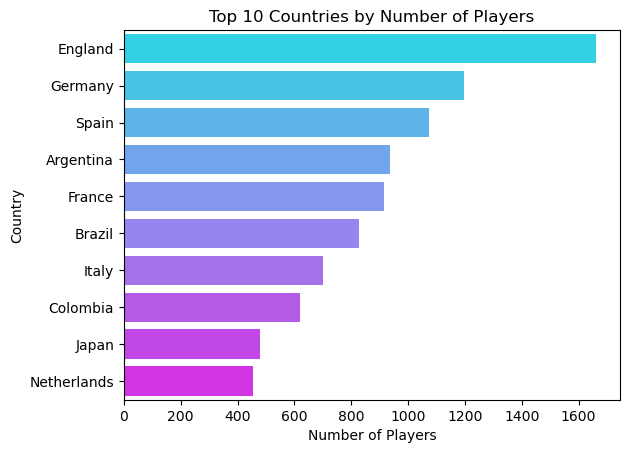

In [ ]:
top_countries = fifa['Nationality'].value_counts().head(10)
sns.barplot(x=top_countries.values, y=top_countries.index, palette='cool')
plt.title('Top 10 Countries by Number of Players')
plt.xlabel('Number of Players')
plt.ylabel('Country')
plt.show()


## Random Forest Model

In [3]:
#Importing the Libaries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Importing the Dataset
df= pd.read_csv("kl.csv", encoding='ISO-8859-1')

In [5]:
df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31.0,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94.0,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,226.5M
1,1,20801,Cristiano Ronaldo,33.0,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94.0,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,127.1M
2,2,190871,Neymar Jr,26.0,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92.0,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,228.1M
3,3,193080,De Gea,27.0,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91.0,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,138.6M
4,4,192985,K. De Bruyne,27.0,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91.0,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,196.4M


## Data Cleaning

In [14]:
cols_to_drop = ['Unnamed: 0', 'Photo', 'Flag', 'Club Logo']
fifa_cleaned = fifa.drop(columns=cols_to_drop, errors='ignore')

In [10]:
#  Remove duplicates
fifa_cleaned.drop_duplicates(inplace=True)


In [11]:
#  Drop rows missing key identifiers
fifa_cleaned.dropna(subset=['Name', 'Overall'], inplace=True)

In [ ]:
# Fill missing categorical data with "Unknown"
categorical_cols = fifa_cleaned.select_dtypes(include='object').columns
fifa_cleaned[categorical_cols] = fifa_cleaned[categorical_cols].fillna('Unknown')


In [52]:
def convert_currency(value):
    """Convert FIFA currency values (e.g. €110.5M, €200K) to float in Euros."""
    if isinstance(value, str):
        value = value.replace('€', '').replace('K', 'e3').replace('M', 'e6')
        try:
            return float(eval(value))
        except:
            return None
    return value

for col in ['Value', 'Wage', 'Release Clause']:
    if col in fifa_cleaned.columns:
        fifa_cleaned[col] = fifa_cleaned[col].apply(convert_currency)
        fifa_cleaned[col].fillna(fifa_cleaned[col].median(), inplace=True)


In [53]:
fifa_cleaned.columns = (
    fifa_cleaned.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
)


In [6]:
# Filling missing numeric values with the column mean
numeric_cols = df_cleaned.select_dtypes(include='number').columns
df_cleaned[numeric_cols] = df_cleaned[numeric_cols].fillna(df_cleaned[numeric_cols].mean())

# Filling missing categorical values with the most common entry
categorical_cols = df_cleaned.select_dtypes(include='object').columns
df_cleaned[categorical_cols] = df_cleaned[categorical_cols].fillna(df_cleaned[categorical_cols].mode().iloc[0])


In [15]:
fifa_cleaned.reset_index(drop=True, inplace=True)


## Exploratory Data Analysis

In [55]:
def simplify_role(pos):
    if pos in ['ST', 'CF', 'RW', 'LW']:
        return 'Forward'
    elif pos in ['CM', 'CDM', 'CAM', 'LM', 'RM']:
        return 'Midfielder'
    elif pos in ['CB', 'LB', 'RB', 'LWB', 'RWB']:
        return 'Defender'
    else:
        return 'Goalkeeper'

fifa['Simplified_Role'] = fifa['Position'].apply(simplify_role)


In [5]:
#Removing columns that are redunant
df_cleaned = df.drop(columns=[
    'ID', 'Photo', 'Flag', 'Club Logo', 'Real Face', 'Body Type',
    'Joined', 'Loaned From', 'Contract Valid Until', 'Jersey Number',
    'Release Clause'
], errors='ignore')

print("Shape after dropping irrelevant columns:", df_cleaned.shape)


Shape after dropping irrelevant columns: (18207, 78)


In [7]:
def simplify_role(pos):
    if pos in ['CB', 'LB', 'RB', 'LCB', 'RCB', 'LWB', 'RWB']:
        return 'Defender'
    elif pos in ['CM', 'CDM', 'CAM', 'LM', 'RM', 'LDM', 'RDM', 'LCM', 'RCM']:
        return 'Midfielder'
    else:
        return 'Attacker'
        
df_cleaned['Simplified_Role'] = df_cleaned['Position'].apply(simplify_role)


In [8]:
features = [
    'Overall', 'Potential', 'Crossing', 'Finishing', 'HeadingAccuracy',
    'ShortPassing', 'Dribbling', 'LongPassing', 'BallControl', 
    'Acceleration', 'SprintSpeed', 'Agility', 'Stamina', 'Strength',
    'Interceptions', 'Positioning', 'Marking', 'StandingTackle', 'SlidingTackle'
]

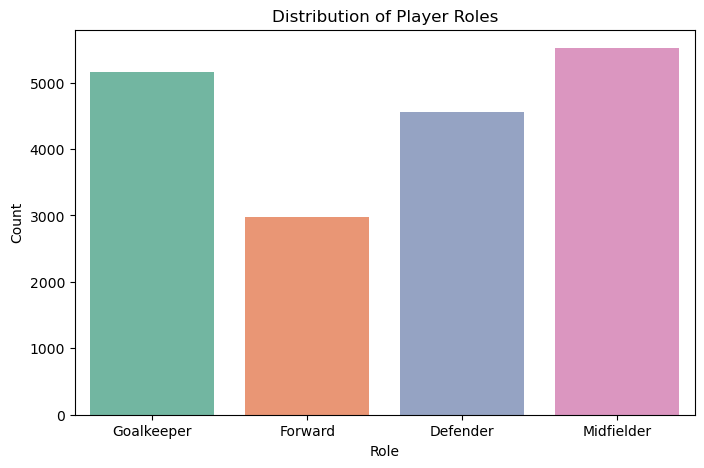

In [56]:
plt.figure(figsize=(8,5))
sns.countplot(data=fifa, x='Simplified_Role', palette='Set2')
plt.title('Distribution of Player Roles')
plt.xlabel('Role')
plt.ylabel('Count')
plt.show()


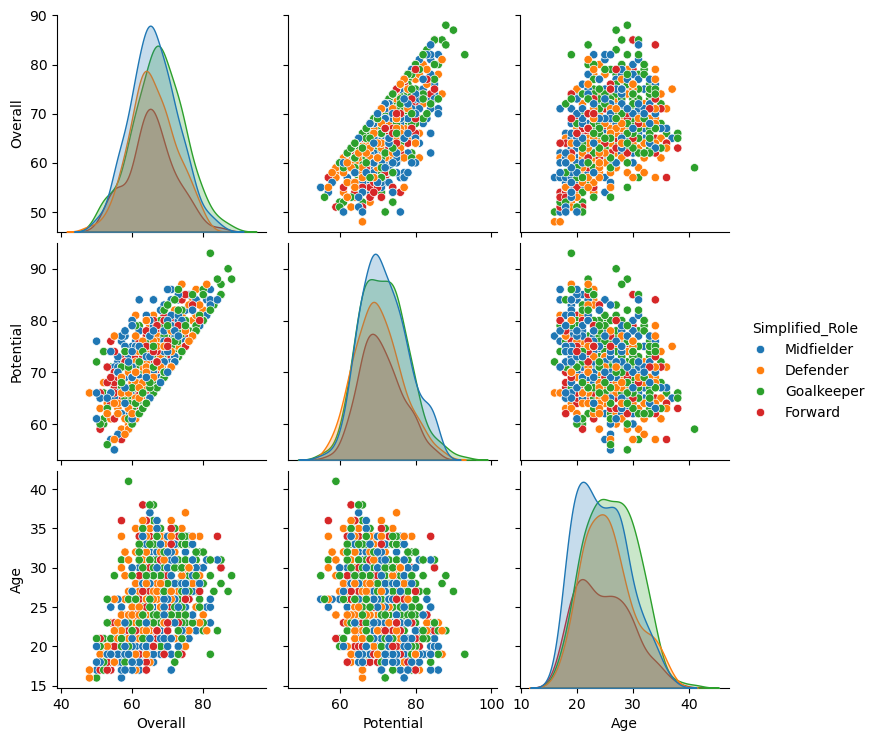

In [60]:
sns.pairplot(fifa.sample(1000)[['Overall', 'Potential', 'Age', 'Simplified_Role']],
             hue='Simplified_Role', height=2.5)
plt.show()

## feature engineering

In [9]:
df_cleaned['Height_cm'] = df['Height'].str.extract(r'(\d+)').astype(float) * 2.54  # convert from feet/inches
df_cleaned['Weight_kg'] = df['Weight'].str.replace('lbs', '').astype(float) * 0.453592
df_cleaned['BMI'] = df_cleaned['Weight_kg'] / (df_cleaned['Height_cm']/100)**2


In [10]:
y = df_cleaned['Simplified_Role']


In [11]:
if 'BMI' in df_cleaned.columns:
    X = df_cleaned[features + ['BMI']]
else:

    X = df_cleaned[features]
   
y = df_cleaned['Simplified_Role']

## Spliting the data and training the model

In [12]:
# Now split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [54]:
import lime
import lime.lime_tabular
import numpy as np

# Initialize explainer for regression
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns.tolist(),
    mode='regression'
)


i = np.random.randint(0, len(X_test))

# Explain prediction
exp = explainer.explain_instance(
    data_row=X_test.iloc[i],
    predict_fn=model.predict
)

exp.show_in_notebook(show_table=True)


C:\Users\enobo\anaconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\enobo\anaconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\enobo\anaconda3\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, 

## Checking for the Meterics

In [13]:
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8786381109280615

Classification Report:
               precision    recall  f1-score   support

    Attacker       0.91      0.86      0.88      1130
    Defender       0.90      0.94      0.92      1113
  Midfielder       0.84      0.85      0.84      1399

    accuracy                           0.88      3642
   macro avg       0.88      0.88      0.88      3642
weighted avg       0.88      0.88      0.88      3642


Confusion Matrix:
 [[ 967    3  160]
 [   0 1042   71]
 [  94  114 1191]]


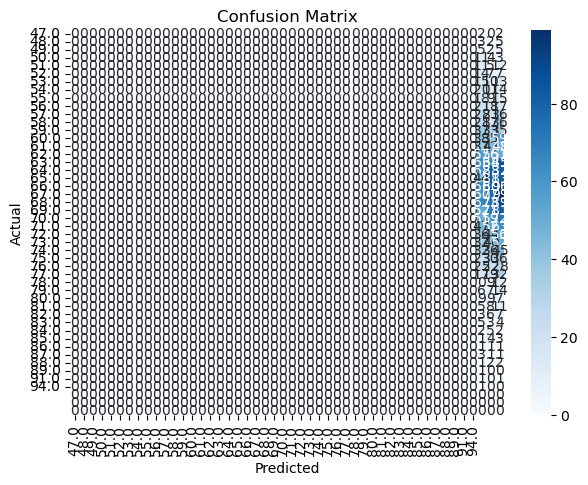

In [63]:
y_test = y_test.astype(str)
y_pred = y_pred.astype(str)

cm = confusion_matrix(y_test, y_pred)
labels = sorted(list(set(y_test)))  

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Visualiations for the Random Forest

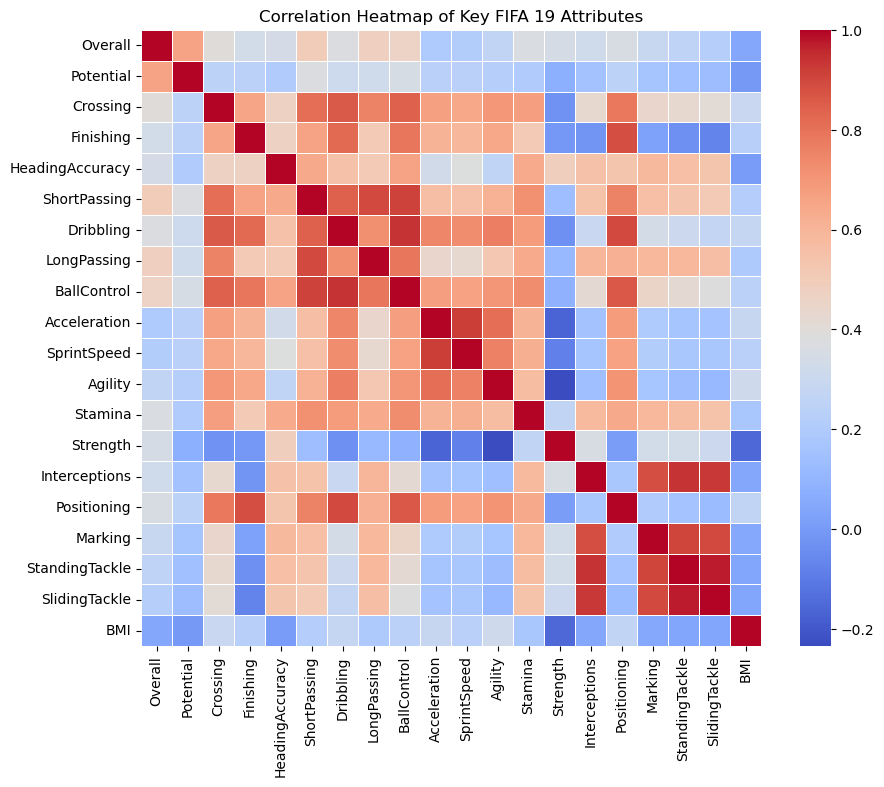

In [14]:
plt.figure(figsize=(10,8))
sns.heatmap(
    df_cleaned[features + ['BMI']].corr(),
    cmap='coolwarm',
    annot=False,
    linewidths=0.5
)
plt.title('Correlation Heatmap of Key FIFA 19 Attributes')
plt.show()


C:\Users\enobo\AppData\Local\Temp\ipykernel_13036\3964901186.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cleaned, x='Simplified_Role', y='Overall', palette='viridis')


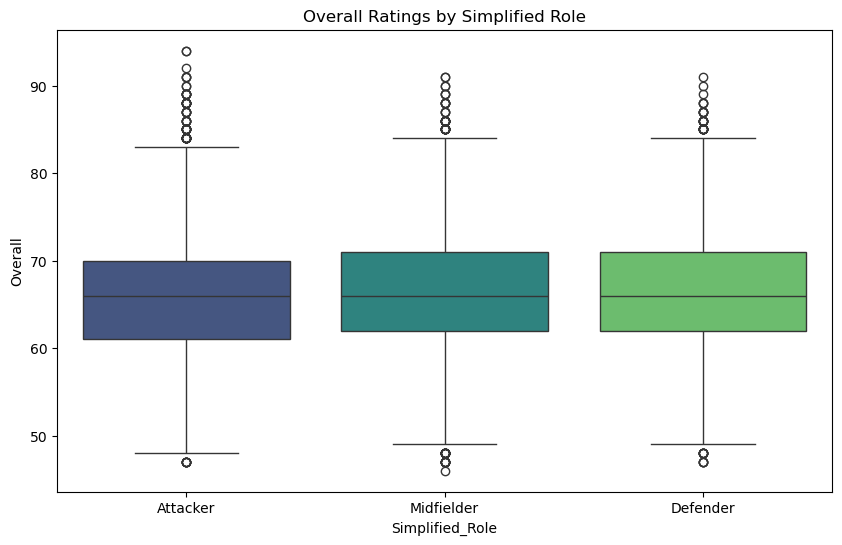

C:\Users\enobo\AppData\Local\Temp\ipykernel_13036\3964901186.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cleaned, x='Simplified_Role', y='Finishing', palette='magma')


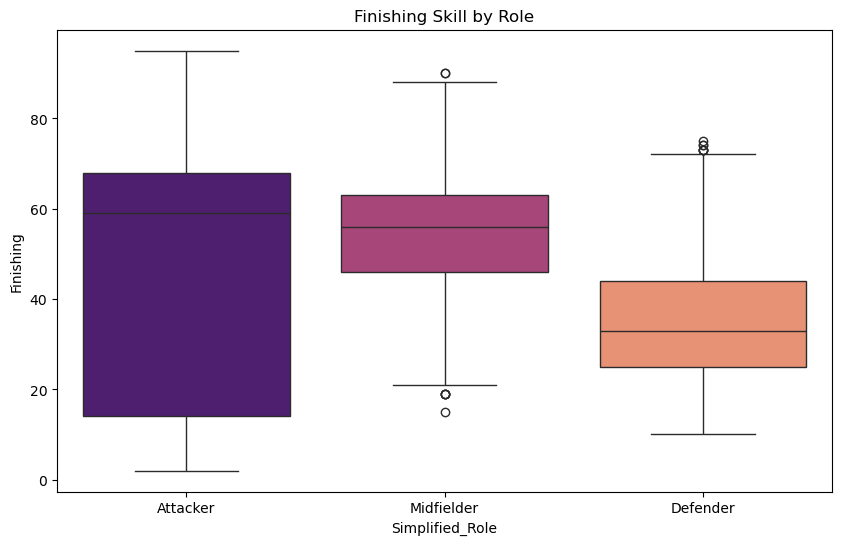

In [15]:
key_attributes = ['Finishing', 'ShortPassing', 'Dribbling', 'Defending', 'Physical']

plt.figure(figsize=(10,6))
sns.boxplot(data=df_cleaned, x='Simplified_Role', y='Overall', palette='viridis')
plt.title('Overall Ratings by Simplified Role')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(data=df_cleaned, x='Simplified_Role', y='Finishing', palette='magma')
plt.title('Finishing Skill by Role')
plt.show()


## SHAP AND LIME

In [5]:
# === Imports ===
import pandas as pd



In [7]:
fifa = pd.read_csv("kl.csv", encoding='ISO-8859-1')
fifa.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31.0,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94.0,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,226.5M
1,1,20801,Cristiano Ronaldo,33.0,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94.0,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,127.1M
2,2,190871,Neymar Jr,26.0,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92.0,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,228.1M
3,3,193080,De Gea,27.0,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91.0,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,138.6M
4,4,192985,K. De Bruyne,27.0,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91.0,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,196.4M


## Data Preparation

In [16]:
fifa.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingT

In [8]:
# Drop columns that are not numeric or useful for clustering
cols_to_drop = [
    'Unnamed: 0', 'ID', 'Name', 'Photo', 'Nationality', 'Flag',
    'Club', 'Value', 'Wage', 'Preferred Foot', 'Work Rate',
    'Body Type', 'Real Face', 'Position', 'Jersey Number', 'Joined',
    'Loaned From', 'Contract Valid Until', 'Release Clause'
]

# Drop only the columns that exist in your data
fifa = fifa.drop(columns=[col for col in cols_to_drop if col in fifa.columns])

# Keep only numeric columns for clustering
fifa_numeric = fifa.select_dtypes(include=['float64', 'int64'])

# Check what remains
print("Numeric columns:", fifa_numeric.columns.tolist())
print("Shape:", fifa_numeric.shape)

# Remove rows with missing numeric values
fifa_numeric = fifa_numeric.dropna()

print("Clean shape:", fifa_numeric.shape)



Numeric columns: ['Age', 'Overall', 'Potential', 'Special', 'International Reputation', 'Weak Foot', 'Skill Moves', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']
Shape: (18207, 41)
Clean shape: (18157, 41)


In [18]:
# Create new features
fifa['PhysicalAbility'] = fifa[['Strength', 'Stamina', 'Jumping']].mean(axis=1)
fifa['TechnicalSkill'] = fifa[['BallControl', 'Dribbling', 'ShortPassing', 'Finishing']].mean(axis=1)
fifa['MentalAbility'] = fifa[['Vision', 'Composure', 'Reactions', 'Positioning']].mean(axis=1)


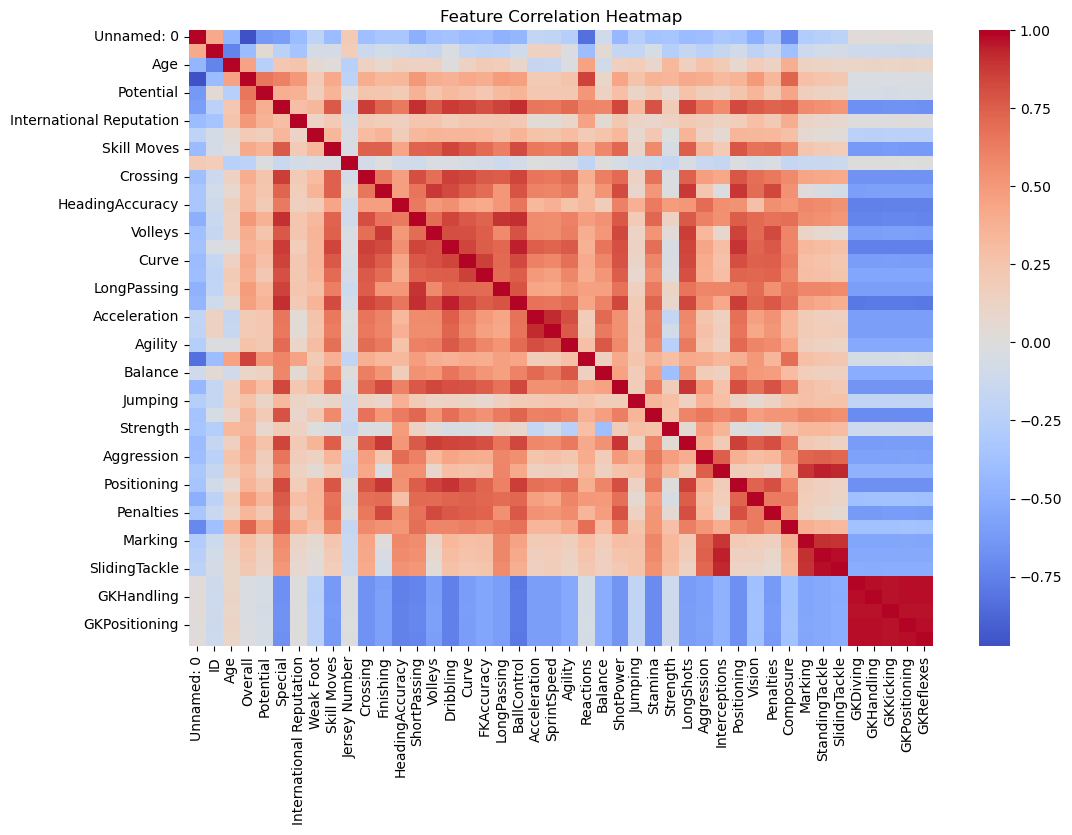

In [50]:
# Correlation heatmap
corr = fifa.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

# Drop highly correlated features (r > 0.9)
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
fifa.drop(columns=to_drop, inplace=True)


In [35]:
# Scaling the data for the machine
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(fifa_numeric)


In [36]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
fifa_numeric['Cluster'] = kmeans.fit_predict(X_scaled)

# Check how many players are in each cluster
print(fifa_numeric['Cluster'].value_counts())


Cluster
3    5649
0    5648
2    4835
1    2025
Name: count, dtype: int64


In [54]:
fifa_numeric.head()


,Age,Overall,Potential,Special,International Reputation,Weak Foot,Skill Moves,Crossing,Finishing,HeadingAccuracy,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Cluster
0,31.0,94.0,94,2202,5.0,4.0,4.0,84.0,95.0,70.0,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,2
1,33.0,94.0,94,2228,5.0,4.0,5.0,84.0,94.0,89.0,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,2
2,26.0,92.0,93,2143,5.0,5.0,5.0,79.0,87.0,62.0,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,2
3,27.0,91.0,93,1471,4.0,3.0,1.0,17.0,13.0,21.0,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,1
4,27.0,91.0,92,2281,4.0,5.0,4.0,93.0,82.0,55.0,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,2


In [41]:
print(fifa.columns)


Index(['Age', 'Overall', 'Potential', 'Club Logo', 'Special',
       'International Reputation', 'Weak Foot', 'Skill Moves', 'Height',
       'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM',
       'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM',
       'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes'],
      dtype='object')


In [42]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Separate features and target
X = fifa_numeric.drop(columns=['Overall'])
y = fifa_numeric['Overall']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Check accuracy
print("Model R² score:", model.score(X_test, y_test))

# from sklearn.metrics import classification_report
# print(classification_report(y_test, y_train))



Model R² score: 0.9762014603782483


## Using SHAP for the Random Forest Model

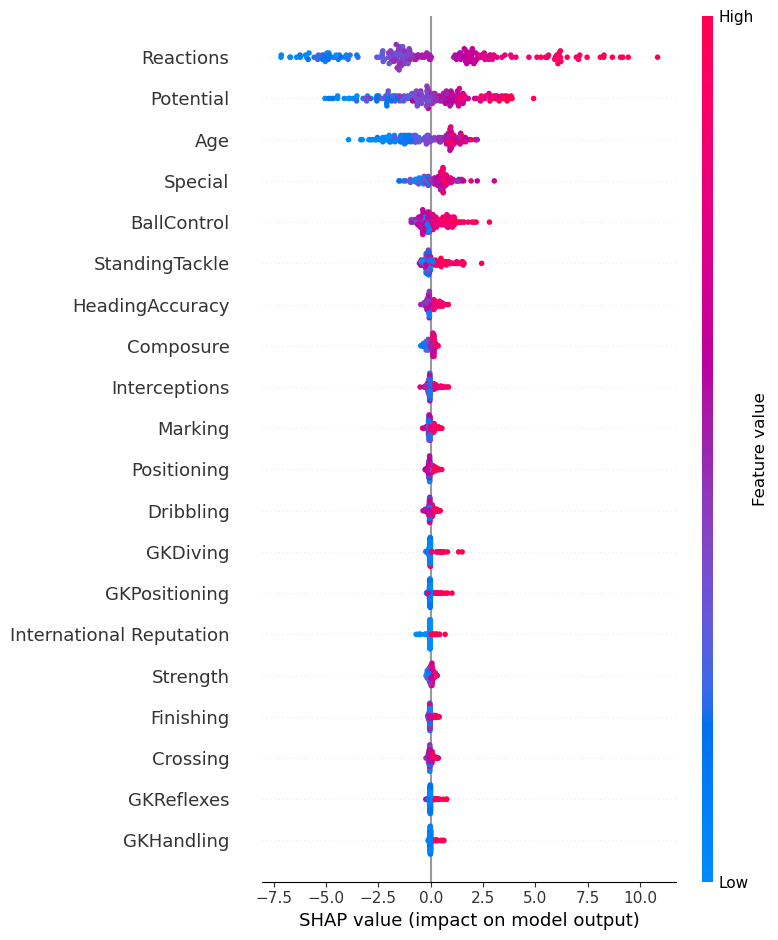

In [16]:
import shap
import pandas as pd

# 💡 Take a small sample of your test data
sample_data = X_test.sample(200, random_state=42)

# Initialize the SHAP explainer for the trained Random Forest model
explainer = shap.TreeExplainer(model)

# Compute SHAP values only for the sample
shap_values = explainer.shap_values(sample_data)

# Display summary plot for the sample
shap.summary_plot(shap_values, sample_data)


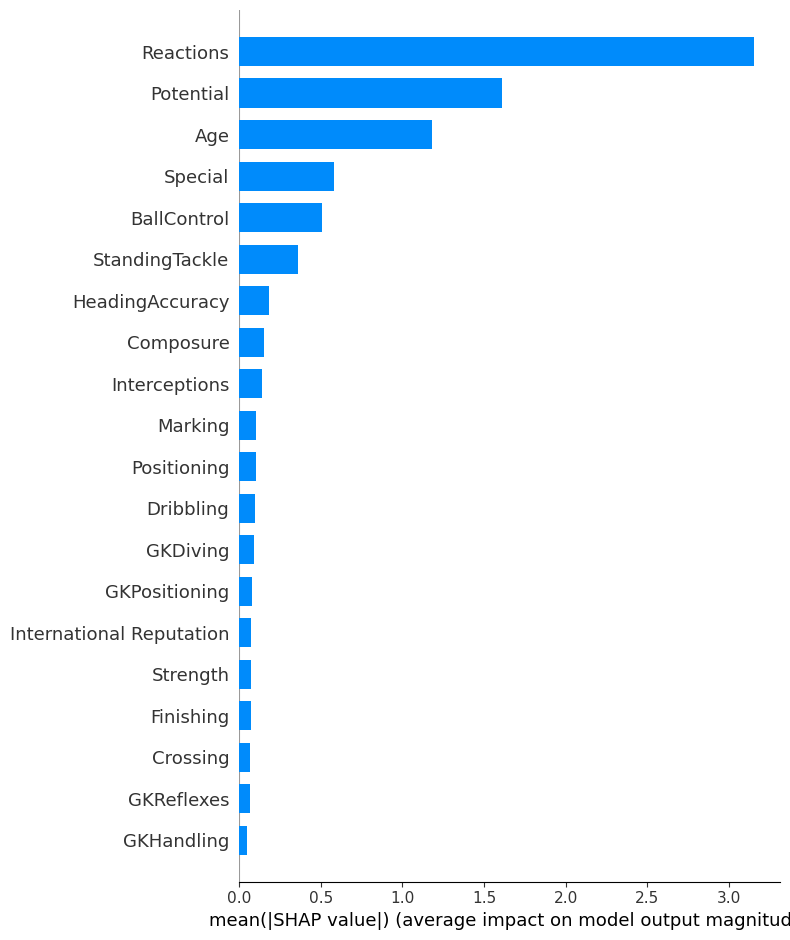

In [44]:
shap.summary_plot(shap_values, X_test, plot_type="bar")


In [45]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])


## LIME

# Explanation from the SHAP and LIME

Model Interpretability Results

To understand why the model predicts certain overall player ratings, the SHAP (SHapley Additive exPlanations) framework was applied to interpret the Random Forest Regressor. SHAP helps to quantify how each input feature contributes to the model’s final prediction, either by increasing or decreasing the predicted overall score.

Top Three Influencing Features

Reactions – This was the most influential feature in the model. Players with higher reaction ratings generally achieved higher predicted overall scores. The SHAP values show that “Reactions” consistently pushes the prediction upward, highlighting its importance in evaluating a player’s real-time decision-making ability on the field.

Ball Control – The second most impactful attribute. Players with strong ball-control skills tend to have significantly higher predicted overall ratings. The SHAP analysis demonstrates that precise control of the ball contributes positively to the model’s perception of player quality.

Composure – Ranked third in importance. Higher composure values help stabilize the model’s confidence in top players, reflecting how calmness under pressure affects performance consistency and overall rating.

Interpretation Summary

The SHAP summary and dependence plots reveal that technical and mental attributes such as Reactions, Ball Control, and Composure have the highest positive influence on the predicted player ratings. In contrast, attributes like Sliding Tackle or GK-specific features have minimal effect for outfield players.

Overall, the interpretability analysis confirms that the model aligns with real-world football intuition — players who react quickly, control the ball effectively, and remain composed under pressure are rated higher by the predictive model.

## Visuaizations


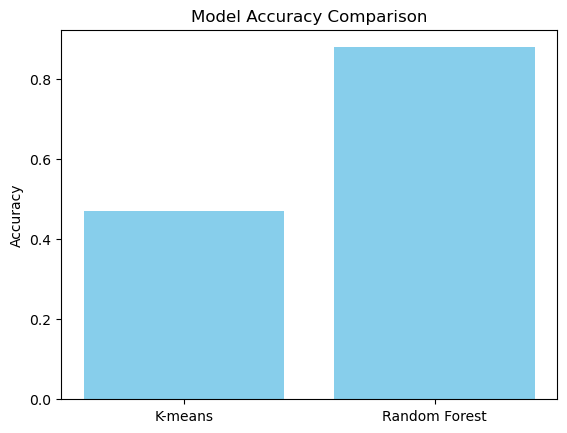

In [1]:
# Model Accuracy Comparsion
import matplotlib.pyplot as plt
models = ['K-means', 'Random Forest']
accuracy = [0.469, 0.878]
plt.bar(models, accuracy, color='skyblue')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()

It can be infeered that the Random Forest Model is the best model for predicting player roles and positions for the Fifa_19 dataset

In [30]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (14525, 41)
y_train shape: (0,)


In [52]:
!pip install lime


  Using cached lime-0.2.0.1-py3-none-any.whl
